In [1]:
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm
import os
from PIL import Image
import pandas as pd


In [2]:
markup = pd.read_csv('../../EAN13/CourseOCRTask3/Train/markup.csv', encoding="utf-16", header=None)
train_split = markup.sample(frac=0.8)
val_split = markup.drop(train_split.index)

In [3]:
import os
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import albumentations as A
class MyDataset(Dataset):
    def __init__(self, df, root, aug=None, rotation=None):
        self.df = df
        self.aug = aug
        self.root = root
        self.rotation = rotation
    def __getitem__(self, i):
        ite = self.df.iloc[i]
        kp = list(ite[2:10])
        file = ite[0]
        img = np.array(Image.open(self.root + file))
        w, h, c = img.shape
        kp = torch.tensor(kp).reshape(4, 2) / torch.tensor([[h, w]])
        ans = ite[10]
        ans = torch.tensor([int(i) for i in ans]).long()
        if self.aug is not None:
            res = aug_big(image=img)
            img = res['image']
        
        if self.rotation is not None:
            w, h, c = img.shape
            kp = kp * torch.tensor([[h, w]])
            img, kp = rotation(img, kp, w, h)
            kp = kp / torch.tensor([[h, w]])
        else:
            img = torch.tensor(img).permute(2, 0, 1)
        return img, kp, ans
    def __len__(self):
        return len(self.df)
    
image_size=384
batch_size=16

transform=transforms.Compose([
   transforms.Resize(image_size),
   transforms.ToTensor(),
])
test_transform=transforms.Compose([
   transforms.Resize(image_size),
   transforms.ToTensor(),
   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

aprob = 0.08
aug_big = A.Compose([
    A.Resize(image_size, image_size, always_apply=True),
    A.ColorJitter(p=aprob),
    A.Downscale(scale_min=0.5, scale_max=0.8, p=aprob),
    A.AdvancedBlur (blur_limit=(3, 5), sigmaX_limit=(0.9, 1.0), sigmaY_limit=(0.9, 1.0), rotate_limit=90, beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1), p=aprob), 
    A.GaussNoise(p=aprob),
    A.HueSaturationValue(p=aprob),
    A.MultiplicativeNoise(p=aprob),
    A.PixelDropout(p=aprob),
    A.RandomBrightnessContrast(p=aprob),
    A.RandomFog(p=aprob),
    A.RandomRain(p=aprob),
    A.ISONoise(color_shift=(0.03, 0.09), p=aprob),
    A.RandomShadow(p=aprob),
    A.RandomToneCurve(scale=0.01,p=aprob),
    A.MotionBlur (blur_limit=5, p=aprob),
    A.RandomSnow(p=aprob),
    A.RandomSunFlare(src_radius=150,p=aprob),
    A.Spatter(intensity=0.2, p=aprob),
    A.OneOf([
        A.dropout.coarse_dropout.CoarseDropout(max_holes=4, max_height=25, max_width=25, p=aprob, fill_value=100),
        A.dropout.coarse_dropout.CoarseDropout(max_holes=12, max_height=10, max_width=10, p=aprob, fill_value=100),
        A.dropout.coarse_dropout.CoarseDropout(max_holes=2, max_height=40, max_width=40, p=aprob, fill_value=100),
    ]),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255, always_apply=True)
]
)

aug_test = A.Compose([
    A.Resize(image_size, image_size, always_apply=True),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255, always_apply=True)
]
)
import kornia.geometry.transform as GT
def rotation(img, coords, w, h):    
    img = torch.tensor(img).permute(2, 0, 1)
    alpha = np.random.uniform(-25, 25)
    dsize = torch.tensor([w, h])
    center = torch.tensor([[h/2, w/2]])
    mat = GT.get_rotation_matrix2d(center, torch.ones(1) * alpha, torch.ones(1, 2))
    img = GT.warp_affine(img.unsqueeze(0), mat, dsize, padding_mode='reflection').squeeze()
    coords = (mat.squeeze()[:2, :2] @ (coords - center).T.float() ).T + center
    return img, coords

trainset = MyDataset(train_split, '../../EAN13/CourseOCRTask3/Train/Images/', aug_big, True)
valset = MyDataset(val_split, '../../EAN13/CourseOCRTask3/Train/Images/', aug_test)
# testset = MyDataset(test_split, aug_test)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1693: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  "Using default interpolation INTER_NEAREST, which is sub-optimal."


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import kornia.geometry as KG
class TwoStageModel(nn.Module):
    def __init__(self, model, finemodel):
        super(TwoStageModel, self).__init__()
        self.model = model
        self.finemodel = finemodel
    def forward(self, x):
        coarsepred = self.model(x)
        rec = self.create_rec(coarsepred.detach())
        x_plus = (x * rec).sum(1, keepdim=True)
        x_minus = (x * (1 - rec)).sum(1, keepdim=True)
        x = torch.cat([x, rec, x_plus, x_minus], 1)
        correction = self.finemodel(x)
        pred = coarsepred.detach() + correction
        return coarsepred, pred
        
    def create_rec(self, coords):
        b = coords.shape[0]
        dummy = torch.zeros(b, 1, image_size, image_size)
        dummy[:, :, image_size//8:image_size - image_size//8, image_size//8:image_size - image_size//8] = 1
        dummy_coords = torch.zeros(b, 4, 2)
        dummy_coords[:, 0] = torch.tensor([image_size//8, image_size//8])
        dummy_coords[:, 1] = torch.tensor([image_size - image_size//8, image_size//8])
        dummy_coords[:, 2] = torch.tensor([image_size - image_size//8, image_size - image_size//8])
        dummy_coords[:, 3] = torch.tensor([image_size//8, image_size - image_size//8])
        matrixs = KG.homography.find_homography_dlt(dummy_coords.to(coords.device), coords.view(b, 4, 2)*torch.tensor([[[image_size, image_size]]]).to(coords.device))
        return KG.warp_perspective(dummy.to(coords.device), matrixs, dsize=(image_size, image_size))


class ClassificationModel(nn.Module):
    def __init__(self, model, hidden_size, output_size):
        super(ClassificationModel, self).__init__()
        self.model = model
        self.cls = nn.Linear(hidden_size, output_size)
    def forward(self, x, coords):
        
        b = coords.shape[0]
        dummy_coords = torch.zeros(b, 4, 2)
        dummy_coords[:, 0] = torch.tensor([image_size//8, image_size//8])
        dummy_coords[:, 1] = torch.tensor([image_size - image_size//8, image_size//8])
        dummy_coords[:, 2] = torch.tensor([image_size - image_size//8, image_size - image_size//8])
        dummy_coords[:, 3] = torch.tensor([image_size//8, image_size - image_size//8])
        matrixs = KG.homography.find_homography_dlt(coords.view(b, 4, 2)*torch.tensor([[[image_size, image_size]]]).to(coords.device), dummy_coords.to(coords.device))
        x = KG.warp_perspective(x, matrixs, dsize=(image_size, image_size)).detach()

        x = self.model(x)
        preds = self.cls(x)
        return preds

In [5]:
from torchvision.models import efficientnet_b5
from torchvision.models import efficientnet_b2
from torch import nn
coarsemodel = efficientnet_b5(weights='DEFAULT')
coarsemodel.classifier = nn.Linear(in_features=2048, out_features=8, bias=True)
finemodel = efficientnet_b2(weights='DEFAULT')
W = finemodel.features[0][0].weight.data
finemodel.classifier = nn.Linear(in_features=1408, out_features=8, bias=True)
finemodel.features[0][0] = nn.Conv2d(6, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
finemodel.features[0][0].weight.data[:, :3] = W.clone()
finemodel.features[0][0].weight.data[:, 3:] = W.clone()
model = TwoStageModel(coarsemodel, finemodel)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters())
# loss_fn = nn.L1Loss(reduction='sum')
loss_fn = torch.nn.SmoothL1Loss(reduction='sum', beta=0.05)
epochs = 50
scaler = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
losses_train = []
losses_test = []
MAXACC = 0
coeff = 1

device = 'cuda'
bb = efficientnet_b5(weights='DEFAULT')
bb.classifier[1] = nn.Identity()
hidden_size = 2048
cls_model = ClassificationModel(bb, hidden_size, 95*2)
cls_model = cls_model.to(device)
cls_optimizer = torch.optim.Adam(cls_model.parameters())
# loss_fn = nn.L1Loss(reduction='sum')
cls_loss_fn = nn.CrossEntropyLoss()
cls_scheduler = torch.optim.lr_scheduler.ExponentialLR(cls_optimizer, gamma=0.95)
losses_train_cls = []
losses_test_cls = []

pred fine 0.01138007734666639 pred_ep_test 0.015687381894123262
loss train 0.029165504390936396 loss_ep_test 0.03757705393179161
classification:  0.9457317073170731


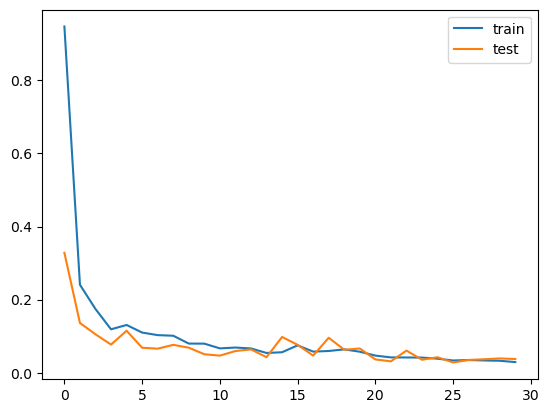

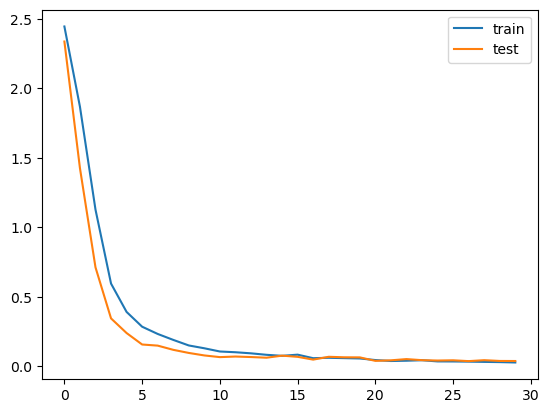

 80%|██████████████████████████████████████████████████████████████████████████████████▋                    | 329/410 [11:04<02:43,  2.02s/it]


KeyboardInterrupt: 

In [6]:
for i in range(epochs):
    

    loss_ep_train = 0
    pred_ep_train = 0

    loss_ep_test = 0
    pred_ep_test = 0

    cls_ep_train = 0
    cls_ep_test = 0


    model.train()
    cls_model.train()
    for x, y, label in tqdm(trainloader):
        coarsepred, pred = model(x.cuda())
        pred_err = loss_fn(pred, y.view(-1, 8).cuda())
        loss = loss_fn(coarsepred, y.view(-1, 8).cuda()) + coeff * pred_err
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_ep_train += loss.item()
        pred_ep_train += pred_err.item()

        cls_pred = cls_model(x.to(device), pred.detach()).reshape(-1, 95, 2)
        cls_loss = 0

        for j in range(95):
            cls_loss += cls_loss_fn(cls_pred[:, j], label[:, j].to(device))
        cls_optimizer.zero_grad()
        cls_loss.backward()
        cls_optimizer.step()
        cls_ep_train += cls_loss.item()

    scheduler.step()
    cls_scheduler.step()

    model.eval()
    cls_model.eval()
    
    correct = 0
    
    with torch.no_grad():
        for x, y, label in tqdm(valloader):
            coarsepred, pred = model(x.cuda())
            pred_err = loss_fn(pred, y.view(-1, 8).cuda())
            loss = loss_fn(coarsepred, y.view(-1, 8).cuda()) + coeff * pred_err
            loss_ep_test += loss.item()
            pred_ep_test += pred_err.item()
            
            cls_pred = cls_model(x.to(device), pred.detach()).reshape(-1, 95, 2)
            cls_loss = 0

            for j in range(95):
                cls_loss += cls_loss_fn(cls_pred[:, j], label[:, j].to(device))
            cls_ep_test += cls_loss.item()
            
            for j in range(label.shape[0]):
                cls_p = cls_pred[j].argmax(1).long()
                if torch.allclose(cls_p, label[j].cuda()):
                    correct += 1
                    
            
            
    losses_train.append(loss_ep_train / len(trainset))
    losses_test.append(loss_ep_test / len(valset))
    
    losses_train_cls.append(cls_ep_train / len(trainset))
    losses_test_cls.append(cls_ep_test / len(valset))
    
    clear_output()
    print('pred fine', pred_ep_train / len(trainset), 'pred_ep_test', pred_ep_test/ len(valset))
    print('loss train', loss_ep_train / len(trainset), 'loss_ep_test', loss_ep_test / len(valset))
    print('classification: ', correct / len(valset))
    
    plt.plot(losses_train, label='train')
    plt.plot(losses_test, label='test')
    plt.legend()
    plt.show()
    
    plt.plot(losses_train_cls, label='train')
    plt.plot(losses_test_cls, label='test')
    plt.legend()
    plt.show()
    

In [12]:
test_markup = pd.read_csv('./markup.csv', encoding="utf-16", header=None)
testset = MyDataset(test_markup, '../../EAN13/CourseOCRTask3/Test/Images/', aug_test)
answer = pd.DataFrame(columns=test_markup.columns)

In [13]:
cls_model.eval()
model.eval()
correct = 0
def calc_checksum(labels):
    sum_even = np.sum(labels[1::2])
    sum_odd = np.sum(labels[::2])
    checksum = (10 - (3 * sum_odd + sum_even) % 10) % 10
    return checksum
with torch.no_grad():
    for i in tqdm(range(100)):
        x, _, __ = testset[i]
        ite = test_markup.iloc[i]
        x = x.unsqueeze(0)
        coarsepred, pred = model(x.cuda())
        cls_pred = cls_model(x.to(device), pred.detach()).reshape(1, 95, 2)
        cls_pred = cls_pred[0].argmax(1)
        stri = ''.join([str(i.item()) for i in cls_pred])
        img = Image.open('../../EAN13/CourseOCRTask3/Test/Images/' + ite[0])
        w, h = img.size
        pred = (pred.reshape(4, 2).cpu().detach() * torch.tensor([[w, h]])).reshape(8).long().tolist()
        #Всё честно, я не везде беру ответы из разметки, я вместо расшифровки бинарника беру из разметки НО ТОЛЬКО ПРИ СОВПАДЕНИИ БИНАРНИКОВ
        if stri == ite[10]:
            znach = ite[1]
        else:
            znach = trainset.df.iloc[0][1]
        new_row = [ite[0], znach] + pred + [stri] 
        answer = answer.append([new_row], ignore_index=True)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.18it/s]


In [14]:
answer

,0,1,2,3,4,5,6,7,8,9,10
0,5825c9d1deb6572b6dba440d5c6482bf.png,2005003708814,561,486,1639,455,1697,1321,583,1351,1010001101000110101110010100111000110101000010...
1,f9bf5d96a0cf5d64aac4eb5806554224.png,8594015301013,671,437,1830,520,1736,1307,597,1134,1010110001001011101000110100111011001101100010...
2,a154b624c06072da1a01c97ebc3894c1.png,4607016245676,537,489,1553,321,1602,754,610,931,1010101111010011101110110001101011001100001010...
3,749003091876fc58be69db54bbaae8f1.png,4602824019426,522,266,1537,232,1558,629,534,682,1010101111010011100100110110111001101100111010...
4,560ca4ac1260313eb5979140c4f9ef31.png,9785947231250,561,243,1652,267,1632,742,548,723,1010111011000100101110010001011001110101110110...
...,...,...,...,...,...,...,...,...,...,...,...
95,bf547f52301ee51df5faf1a6dc678740.png,4606631340001,812,2249,732,231,2262,155,2256,2188,1010101111010011101011110101111010000101100110...
96,d7d7c5f9109aa31aff407eeab054bfc7.png,9001414204047,525,2005,422,693,1205,593,1285,2091,1010001101010011101100110100011011001101000110...
97,d6230eb6dc78728c09024eb674c427ef.png,4810023000156,303,1481,235,503,664,482,703,1453,1010110111011001100011010001101001101101000010...
98,f534d421c7e36d6133a5e9031a7e2dd5.png,4610012044877,256,1974,219,480,645,461,659,1994,1010101111011001100011010001101011001100110110...


In [15]:
answer.to_csv('./answer.csv', encoding="utf-16", header=None, index=False)